# PyTorchで深層強化学習（DQN、DoubleDQN）を実装してみた

http://www.ie110704.net/2017/10/15/pytorch%E3%81%A7%E6%B7%B1%E5%B1%A4%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%EF%BC%88dqn%E3%80%81doubledqn%EF%BC%89%E3%82%92%E5%AE%9F%E8%A3%85%E3%81%97%E3%81%A6%E3%81%BF%E3%81%9F/

In [10]:
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [11]:
import gym

# 環境の確認
env = gym.make("CartPole-v0")
print("observation space num: ", env.observation_space.shape[0])
print("action space num: ", env.action_space.n)

pobs = env.reset()
done = False
while not done:
    act = env.action_space.sample()
    obs, reward, done, _ = env.step(act)
    print(pobs, act, reward, obs, done)
    pobs = obs

observation space num:  4
action space num:  2
[-0.01407619  0.04613288  0.00023774  0.03912595] 1 1.0 [-0.01315353  0.24125142  0.00102026 -0.25348196] False
[-0.01315353  0.24125142  0.00102026 -0.25348196] 1 1.0 [-0.0083285   0.43635879 -0.00404938 -0.5458429 ] False
[-0.0083285   0.43635879 -0.00404938 -0.5458429 ] 0 1.0 [ 0.00039867  0.24129397 -0.01496624 -0.25443858] False
[ 0.00039867  0.24129397 -0.01496624 -0.25443858] 1 1.0 [ 0.00522455  0.43662638 -0.02005501 -0.5518043 ] False
[ 0.00522455  0.43662638 -0.02005501 -0.5518043 ] 1 1.0 [ 0.01395708  0.63202416 -0.03109109 -0.85073781] False
[ 0.01395708  0.63202416 -0.03109109 -0.85073781] 0 1.0 [ 0.02659756  0.43733963 -0.04810585 -0.56799146] False
[ 0.02659756  0.43733963 -0.04810585 -0.56799146] 1 1.0 [ 0.03534436  0.63310217 -0.05946568 -0.87543322] False
[ 0.03534436  0.63310217 -0.05946568 -0.87543322] 1 1.0 [ 0.0480064   0.82897988 -0.07697434 -1.18620306] False
[ 0.0480064   0.82897988 -0.07697434 -1.18620306] 1 1.0 [

Train
epoch	EPSILON	reward	total_step	elapsed_time
1000	1.0	20.766	22766	23.8746018409729[sec]
2000	1.0	20.28	45046	25.199968338012695[sec]
3000	1.0	20.091	67137	22.17655849456787[sec]
4000	1.0	19.603	88740	20.254279851913452[sec]
5000	1.0	20.153	110893	22.011710166931152[sec]
6000	1.0	20.581	133474	22.534866094589233[sec]
7000	1.0	20.703	156177	25.8447322845459[sec]
8000	1.0	20.522	178699	23.233219385147095[sec]
9000	1.0	20.298	200997	21.216121912002563[sec]
10000	1.0	20.685	223682	29.865946054458618[sec]


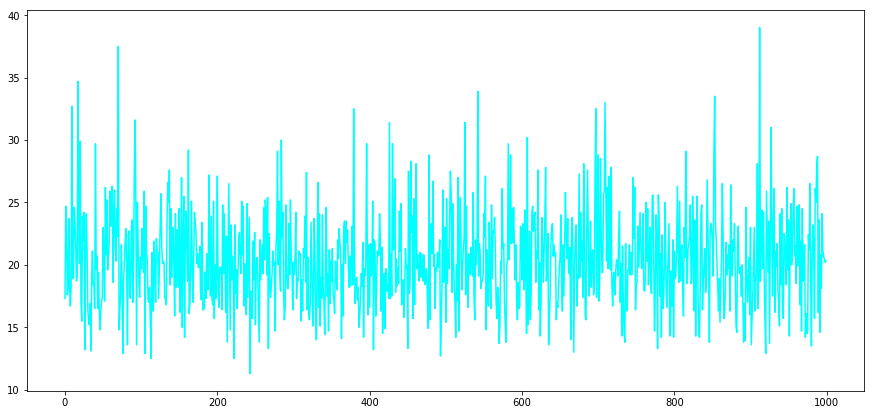

In [12]:


# 環境
MONITOR = False
env = gym.make("CartPole-v0")
if MONITOR:
    env = wrappers.Monitor(env, "./tmp", force=True)

obs_num = env.observation_space.shape[0]
acts_num = env.action_space.n
HIDDEN_SIZE = 100

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(obs_num, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc4 = nn.Linear(HIDDEN_SIZE, acts_num)

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        y = F.relu(self.fc4(h))
        return y

# 定数
EPOCH_NUM = 10000 # エポック数
STEP_MAX = 200 # 最高ステップ数
MEMORY_SIZE = 200 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 50 # バッチサイズ
EPSILON = 1.0 # ε-greedy法
EPSILON_DECREASE = 0.0001 # εの減少値
EPSILON_MIN = 0.1 # εの下限
START_REDUCE_EPSILON = 200 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.97 # 割引率
LOG_FREQ = 1000 # ログ出力の間隔

# モデル
Q = NN() # 近似Q関数
Q_ast = copy.deepcopy(Q)
optimizer = optim.RMSprop(Q.parameters(), lr=0.00015, alpha=0.95, eps=0.01)

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト

# 学習開始
print("Train")
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    step = 0 # ステップ数
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    while not done and step < STEP_MAX:
        if MONITOR:
            env.render()
        # 行動選択
        pact = env.action_space.sample()
        # ε-greedy法
        if np.random.rand() > EPSILON:
            # 最適な行動を予測
            pobs_ = np.array(pobs, dtype="float32").reshape((1, obs_num))
            pobs_ = Variable(torch.from_numpy(pobs_))
            pact = Q(pobs_)
            maxs, indices = torch.max(pact.data, 1)
            pact = indices.numpy()[0]
        # 行動
        obs, reward, done, _ = env.step(pact)
        if done:
            reward = -1
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 状態、行動、報酬、行動後の状態、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                memory_ = np.random.permutation(memory)
                memory_idx = range(len(memory_))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory_[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y
                    pobss_ = Variable(torch.from_numpy(pobss))
                    q = Q(pobss_)
                    obss_ = Variable(torch.from_numpy(obss))
                    maxs, indices = torch.max(Q_ast(obss_).data, 1)
                    maxq = maxs.numpy() # maxQ
                    target = copy.deepcopy(q.data.numpy())
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j]) # 教師信号
                    # Perform a gradient descent step
                    optimizer.zero_grad()
                    loss = nn.MSELoss()(q, Variable(torch.from_numpy(target)))
                    loss.backward()
                    optimizer.step()
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
        # εの減少abs
        if EPSILON < EPSILON_MIN and total_step < START_REDUCE_EPSILON:
            EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        step += 1
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    if (epoch+1) % LOG_FREQ == 0:
        r = sum(total_rewards[((epoch+1)-LOG_FREQ):(epoch+1)])/LOG_FREQ # ログ出力間隔での平均累積報酬
        elapsed_time = time.time()-start
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
if MONITOR:
    env.render(close=True)

plt.figure(figsize=(15,7))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.show()